# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
import helpers

In [2]:
# defining dataset names and paths
base_url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/"
dataset = "processed-celeba-small.zip"
base_folder = "data"

In [3]:
# can comment out after executing
# download and extract dataset using helpers
helpers.download_dataset(dataset, base_url, folder_to_extract=base_folder)

Dataset: processed-celeba-small.zip already present in folder: data


In [25]:
helpers.extract_dataset(dataset, base_folder)

data/processed-celeba-small.zip


In [27]:
data_dir = './processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [33]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [36]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), # resize to image_size
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    
    data_loader = DataLoader(dataset=dataset, 
                              batch_size=batch_size, shuffle=True)
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [72]:
# Define function hyperparameters
batch_size = 20
img_size = 32

In [73]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size, data_dir)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

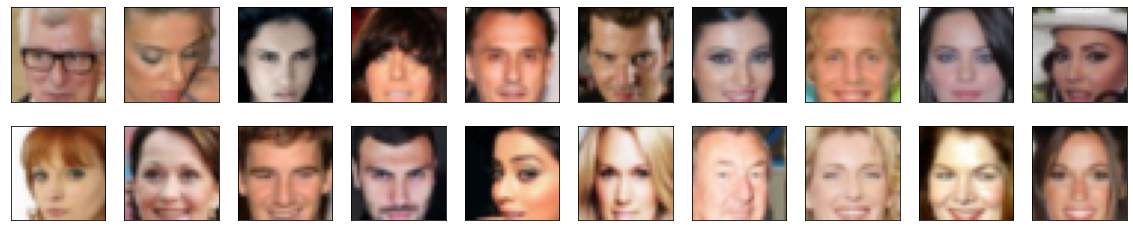

In [74]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [75]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x    

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9373)
Max:  tensor(0.7176)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [61]:
import torch.nn as nn
import torch.nn.functional as F

In [92]:
# Helper to create conv2d functions with BatchNorm if need it 
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [93]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # complete init function
        # 32 by 32 by 3 channels
        self.conv_1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, batch_norm=False)
        # 16 by 16 , out_channels to be twice as prev
        self.conv_2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4)
        # 8 by 8 
        self.conv_3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4)
        # out: 4 by 4
        
        self.fc = nn.Linear(in_features=conv_dim*4*4*4, out_features=1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = F.leaky_relu(self.conv_1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv_2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv_3(x), negative_slope=0.2)
        
        # flatten the output 
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
     
        return x

In [94]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [95]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers_t = []
        
    convt = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)            

    # append conv layer
    layers_t.append(convt)

    if batch_norm:
        # append batchnorm layer
        layers_t.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers_t)

In [96]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # Flatten the array 
        self.fc = nn.Linear(z_size, out_features=conv_dim*4*4*4)
        
        # Transpose the layers
        # 4 by 4, depth conv_dim * 4
        self.deconv_1 = deconv(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4)
        # out: 8 by 8, depth: conv_dim * 2
        self.deconv_2 = deconv(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4)
        # out: 16 by 16, depth: conv_dim 
        self.deconv_3 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=4, batch_norm=True)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        # Reshape into a deep layer of conv_dim*4  by  4 by 4  = 128 (input to the deconv layer)
        x = x.view(-1, self.conv_dim*4, 4, 4) 
        
        
        x = F.relu(self.deconv_1(x))
        x = F.relu(self.deconv_2(x))
        x = F.tanh(self.deconv_3(x))
        
        return x

In [97]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/udacity/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [98]:
from torch.nn import init

In [102]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    mean = 0.0 
    st_dev = 0.02
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        init.normal_(m.weight.data, mean=mean, std=st_dev)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [103]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [104]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv_1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv_2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1),

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [106]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # create labels of ones
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [107]:
def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    # Create labels of zeroes
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # Calculate the loss 
    loss = criterion(D_out.squeeze(), labels)    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [108]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.99

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1,beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [109]:
def train(D, G, n_epochs, pkl_file='train_samples_faces.pkl', print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()            
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train the generator with an adversarial loss
            # Generate random data from batch_size and z_size
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            # Generate fake images with the Generator 
            fake_imgs = G(z)
            # Pass the images to the Discrimitator
            d_fake_imgs = D(fake_imgs)
            # Calculate the loss
            d_fake_loss = fake_loss(d_fake_imgs)
            
            # Add the loss and perform backpropagation 
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            # Update weights
            d_optimizer.step()
            
            # ===============================================
            #      TRAINING THE GENERATOR TO BE LIKE REAL
            # ===============================================            
            g_optimizer.zero_grad()
            
            # Generate fake images 
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            # Pass it to the discriminator with labels flipped
            D_fake = D(fake_images)
            # compute the real loss
            g_loss = real_loss(D_fake)
            
            # Do backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open(pkl_file, 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [110]:
# set number of epochs 
n_epochs = 100
picke_file = 'train_samples_faces.pkl'

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/home/udacity/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3532 | g_loss: 1.0957
Epoch [    1/  100] | d_loss: 0.1656 | g_loss: 3.6070
Epoch [    1/  100] | d_loss: 0.0568 | g_loss: 4.3540
Epoch [    1/  100] | d_loss: 0.0171 | g_loss: 5.4123
Epoch [    1/  100] | d_loss: 0.0125 | g_loss: 5.5590
Epoch [    1/  100] | d_loss: 0.0063 | g_loss: 5.8707
Epoch [    1/  100] | d_loss: 0.0077 | g_loss: 6.9949
Epoch [    1/  100] | d_loss: 0.0127 | g_loss: 7.3702
Epoch [    1/  100] | d_loss: 0.0503 | g_loss: 6.1205
Epoch [    1/  100] | d_loss: 0.0108 | g_loss: 5.9206
Epoch [    1/  100] | d_loss: 0.0037 | g_loss: 6.5548
Epoch [    1/  100] | d_loss: 0.0027 | g_loss: 6.8149
Epoch [    1/  100] | d_loss: 0.0021 | g_loss: 7.2255
Epoch [    1/  100] | d_loss: 0.0033 | g_loss: 6.7110
Epoch [    1/  100] | d_loss: 0.0021 | g_loss: 6.8849
Epoch [    1/  100] | d_loss: 0.0034 | g_loss: 6.3517
Epoch [    1/  100] | d_loss: 0.0006 | g_loss: 8.5913
Epoch [    1/  100] | d_loss: 0.0015 | g_loss: 7.1289
Epoch [    1/  100] | d_loss

Epoch [    2/  100] | d_loss: 0.9852 | g_loss: 1.1994
Epoch [    2/  100] | d_loss: 1.3547 | g_loss: 1.7539
Epoch [    2/  100] | d_loss: 1.2248 | g_loss: 1.0848
Epoch [    2/  100] | d_loss: 1.0299 | g_loss: 1.2485
Epoch [    2/  100] | d_loss: 0.7939 | g_loss: 1.0625
Epoch [    2/  100] | d_loss: 0.9195 | g_loss: 1.3564
Epoch [    2/  100] | d_loss: 0.7777 | g_loss: 1.2322
Epoch [    2/  100] | d_loss: 1.1253 | g_loss: 1.1600
Epoch [    2/  100] | d_loss: 0.8692 | g_loss: 1.7018
Epoch [    2/  100] | d_loss: 0.7385 | g_loss: 1.7095
Epoch [    2/  100] | d_loss: 1.1249 | g_loss: 0.9456
Epoch [    2/  100] | d_loss: 0.8687 | g_loss: 2.0955
Epoch [    2/  100] | d_loss: 0.9483 | g_loss: 2.3199
Epoch [    2/  100] | d_loss: 0.7532 | g_loss: 1.5848
Epoch [    2/  100] | d_loss: 1.1136 | g_loss: 1.2587
Epoch [    2/  100] | d_loss: 1.1408 | g_loss: 0.9842
Epoch [    2/  100] | d_loss: 1.1114 | g_loss: 1.1073
Epoch [    2/  100] | d_loss: 0.9396 | g_loss: 1.5925
Epoch [    2/  100] | d_loss

Epoch [    4/  100] | d_loss: 0.8621 | g_loss: 0.7763
Epoch [    4/  100] | d_loss: 1.1223 | g_loss: 2.2291
Epoch [    4/  100] | d_loss: 0.5405 | g_loss: 2.1380
Epoch [    4/  100] | d_loss: 0.4530 | g_loss: 2.2459
Epoch [    4/  100] | d_loss: 0.6458 | g_loss: 2.1591
Epoch [    4/  100] | d_loss: 1.1576 | g_loss: 2.1233
Epoch [    4/  100] | d_loss: 0.7896 | g_loss: 1.3676
Epoch [    4/  100] | d_loss: 0.6491 | g_loss: 1.3985
Epoch [    4/  100] | d_loss: 0.7002 | g_loss: 2.6584
Epoch [    4/  100] | d_loss: 0.9481 | g_loss: 1.4582
Epoch [    4/  100] | d_loss: 0.4769 | g_loss: 1.4429
Epoch [    4/  100] | d_loss: 0.3682 | g_loss: 1.9131
Epoch [    4/  100] | d_loss: 0.6564 | g_loss: 1.9492
Epoch [    4/  100] | d_loss: 0.6494 | g_loss: 1.6415
Epoch [    4/  100] | d_loss: 0.8649 | g_loss: 1.1803
Epoch [    4/  100] | d_loss: 0.8535 | g_loss: 1.4928
Epoch [    4/  100] | d_loss: 1.0518 | g_loss: 1.5793
Epoch [    4/  100] | d_loss: 0.7347 | g_loss: 2.0593
Epoch [    4/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.8136 | g_loss: 1.3613
Epoch [    6/  100] | d_loss: 0.5895 | g_loss: 0.9903
Epoch [    6/  100] | d_loss: 0.5342 | g_loss: 2.2772
Epoch [    6/  100] | d_loss: 1.5777 | g_loss: 3.5284
Epoch [    6/  100] | d_loss: 0.9832 | g_loss: 2.4678
Epoch [    6/  100] | d_loss: 1.0232 | g_loss: 1.5750
Epoch [    6/  100] | d_loss: 0.7210 | g_loss: 1.3965
Epoch [    6/  100] | d_loss: 0.8160 | g_loss: 2.9196
Epoch [    6/  100] | d_loss: 1.3353 | g_loss: 0.8425
Epoch [    6/  100] | d_loss: 0.3532 | g_loss: 1.6924
Epoch [    6/  100] | d_loss: 0.7671 | g_loss: 1.8170
Epoch [    6/  100] | d_loss: 1.2115 | g_loss: 3.0488
Epoch [    6/  100] | d_loss: 1.4526 | g_loss: 0.8528
Epoch [    6/  100] | d_loss: 0.6917 | g_loss: 2.2126
Epoch [    6/  100] | d_loss: 0.5093 | g_loss: 1.6845
Epoch [    6/  100] | d_loss: 0.6815 | g_loss: 0.9509
Epoch [    6/  100] | d_loss: 0.8955 | g_loss: 1.3265
Epoch [    6/  100] | d_loss: 0.3792 | g_loss: 1.8732
Epoch [    6/  100] | d_loss

Epoch [    7/  100] | d_loss: 0.5895 | g_loss: 1.7157
Epoch [    7/  100] | d_loss: 0.5806 | g_loss: 2.3532
Epoch [    7/  100] | d_loss: 0.8142 | g_loss: 2.3735
Epoch [    7/  100] | d_loss: 0.5058 | g_loss: 2.5150
Epoch [    7/  100] | d_loss: 0.3579 | g_loss: 1.8287
Epoch [    7/  100] | d_loss: 0.8340 | g_loss: 1.4542
Epoch [    7/  100] | d_loss: 0.6988 | g_loss: 1.1240
Epoch [    7/  100] | d_loss: 0.6035 | g_loss: 2.3278
Epoch [    7/  100] | d_loss: 0.7401 | g_loss: 1.9164
Epoch [    7/  100] | d_loss: 0.5287 | g_loss: 2.5336
Epoch [    7/  100] | d_loss: 0.8708 | g_loss: 1.5773
Epoch [    7/  100] | d_loss: 0.3408 | g_loss: 1.8207
Epoch [    7/  100] | d_loss: 0.9435 | g_loss: 3.0449
Epoch [    7/  100] | d_loss: 0.5471 | g_loss: 1.4986
Epoch [    7/  100] | d_loss: 1.2104 | g_loss: 1.4855
Epoch [    7/  100] | d_loss: 0.4553 | g_loss: 3.1406
Epoch [    7/  100] | d_loss: 0.4841 | g_loss: 3.0581
Epoch [    7/  100] | d_loss: 0.9412 | g_loss: 0.7480
Epoch [    7/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.7427 | g_loss: 1.7037
Epoch [    9/  100] | d_loss: 0.9831 | g_loss: 2.8730
Epoch [    9/  100] | d_loss: 0.5029 | g_loss: 2.1395
Epoch [    9/  100] | d_loss: 0.4295 | g_loss: 2.1372
Epoch [    9/  100] | d_loss: 0.5255 | g_loss: 2.2606
Epoch [    9/  100] | d_loss: 0.7815 | g_loss: 1.8333
Epoch [    9/  100] | d_loss: 0.3854 | g_loss: 3.2209
Epoch [    9/  100] | d_loss: 0.5791 | g_loss: 2.3567
Epoch [    9/  100] | d_loss: 0.3878 | g_loss: 2.7771
Epoch [    9/  100] | d_loss: 0.6098 | g_loss: 2.6823
Epoch [    9/  100] | d_loss: 0.5076 | g_loss: 3.0713
Epoch [    9/  100] | d_loss: 0.3893 | g_loss: 2.7896
Epoch [    9/  100] | d_loss: 0.5345 | g_loss: 2.7527
Epoch [    9/  100] | d_loss: 0.6514 | g_loss: 2.4857
Epoch [    9/  100] | d_loss: 0.2311 | g_loss: 3.8905
Epoch [    9/  100] | d_loss: 0.1718 | g_loss: 3.7937
Epoch [    9/  100] | d_loss: 0.6985 | g_loss: 2.3068
Epoch [    9/  100] | d_loss: 0.4924 | g_loss: 2.6480
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.7243 | g_loss: 3.6164
Epoch [   11/  100] | d_loss: 0.6752 | g_loss: 2.0369
Epoch [   11/  100] | d_loss: 0.8642 | g_loss: 3.5073
Epoch [   11/  100] | d_loss: 0.3943 | g_loss: 2.8385
Epoch [   11/  100] | d_loss: 0.7728 | g_loss: 2.1549
Epoch [   11/  100] | d_loss: 0.6639 | g_loss: 2.5963
Epoch [   11/  100] | d_loss: 0.1533 | g_loss: 2.8673
Epoch [   11/  100] | d_loss: 0.1983 | g_loss: 3.0523
Epoch [   11/  100] | d_loss: 0.3089 | g_loss: 1.2255
Epoch [   11/  100] | d_loss: 0.6862 | g_loss: 2.0932
Epoch [   11/  100] | d_loss: 0.4725 | g_loss: 3.2271
Epoch [   11/  100] | d_loss: 0.8754 | g_loss: 2.1756
Epoch [   11/  100] | d_loss: 0.3421 | g_loss: 2.0957
Epoch [   11/  100] | d_loss: 0.5305 | g_loss: 3.9376
Epoch [   11/  100] | d_loss: 0.7978 | g_loss: 2.5621
Epoch [   11/  100] | d_loss: 0.5918 | g_loss: 3.4129
Epoch [   11/  100] | d_loss: 0.1564 | g_loss: 2.4941
Epoch [   11/  100] | d_loss: 0.9519 | g_loss: 1.4569
Epoch [   11/  100] | d_loss

Epoch [   12/  100] | d_loss: 0.4574 | g_loss: 0.7154
Epoch [   12/  100] | d_loss: 0.2987 | g_loss: 2.0001
Epoch [   12/  100] | d_loss: 0.1947 | g_loss: 3.0407
Epoch [   12/  100] | d_loss: 0.2028 | g_loss: 2.6905
Epoch [   12/  100] | d_loss: 0.4428 | g_loss: 2.5068
Epoch [   12/  100] | d_loss: 0.2086 | g_loss: 2.1134
Epoch [   12/  100] | d_loss: 0.6657 | g_loss: 2.2302
Epoch [   12/  100] | d_loss: 0.2470 | g_loss: 1.8488
Epoch [   12/  100] | d_loss: 0.4043 | g_loss: 3.5073
Epoch [   12/  100] | d_loss: 0.4104 | g_loss: 2.9647
Epoch [   12/  100] | d_loss: 0.2169 | g_loss: 3.3289
Epoch [   12/  100] | d_loss: 0.9399 | g_loss: 2.8759
Epoch [   12/  100] | d_loss: 0.3576 | g_loss: 2.5802
Epoch [   12/  100] | d_loss: 0.3766 | g_loss: 2.7778
Epoch [   12/  100] | d_loss: 0.3830 | g_loss: 3.3113
Epoch [   12/  100] | d_loss: 0.5735 | g_loss: 2.8576
Epoch [   13/  100] | d_loss: 0.2175 | g_loss: 3.8080
Epoch [   13/  100] | d_loss: 0.2462 | g_loss: 2.0250
Epoch [   13/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.2641 | g_loss: 2.2602
Epoch [   14/  100] | d_loss: 0.7846 | g_loss: 2.8387
Epoch [   14/  100] | d_loss: 0.1414 | g_loss: 3.1210
Epoch [   14/  100] | d_loss: 0.6419 | g_loss: 2.6827
Epoch [   14/  100] | d_loss: 0.3253 | g_loss: 1.9001
Epoch [   14/  100] | d_loss: 0.2818 | g_loss: 3.2749
Epoch [   14/  100] | d_loss: 0.4266 | g_loss: 1.3692
Epoch [   14/  100] | d_loss: 0.4486 | g_loss: 1.1933
Epoch [   14/  100] | d_loss: 0.2585 | g_loss: 2.3828
Epoch [   14/  100] | d_loss: 0.9064 | g_loss: 1.9008
Epoch [   14/  100] | d_loss: 0.7617 | g_loss: 3.5300
Epoch [   14/  100] | d_loss: 0.8681 | g_loss: 1.7783
Epoch [   14/  100] | d_loss: 1.0116 | g_loss: 2.8120
Epoch [   14/  100] | d_loss: 0.2214 | g_loss: 2.8289
Epoch [   14/  100] | d_loss: 0.4291 | g_loss: 1.7151
Epoch [   14/  100] | d_loss: 0.2111 | g_loss: 2.5058
Epoch [   14/  100] | d_loss: 0.4210 | g_loss: 4.6410
Epoch [   14/  100] | d_loss: 0.2880 | g_loss: 4.1212
Epoch [   14/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.7084 | g_loss: 4.1714
Epoch [   16/  100] | d_loss: 0.6523 | g_loss: 2.3929
Epoch [   16/  100] | d_loss: 0.1298 | g_loss: 3.2179
Epoch [   16/  100] | d_loss: 0.5628 | g_loss: 2.7921
Epoch [   16/  100] | d_loss: 0.0740 | g_loss: 3.0096
Epoch [   16/  100] | d_loss: 0.5889 | g_loss: 1.6481
Epoch [   16/  100] | d_loss: 0.3179 | g_loss: 4.9924
Epoch [   16/  100] | d_loss: 0.2915 | g_loss: 4.1706
Epoch [   16/  100] | d_loss: 0.1916 | g_loss: 5.2287
Epoch [   16/  100] | d_loss: 0.3209 | g_loss: 3.1654
Epoch [   16/  100] | d_loss: 0.8039 | g_loss: 1.3465
Epoch [   16/  100] | d_loss: 0.7638 | g_loss: 1.2743
Epoch [   16/  100] | d_loss: 0.2658 | g_loss: 4.0104
Epoch [   16/  100] | d_loss: 0.3432 | g_loss: 3.5828
Epoch [   16/  100] | d_loss: 0.2778 | g_loss: 1.5233
Epoch [   16/  100] | d_loss: 1.1716 | g_loss: 5.2031
Epoch [   16/  100] | d_loss: 0.4462 | g_loss: 1.6367
Epoch [   16/  100] | d_loss: 0.4889 | g_loss: 3.6422
Epoch [   16/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.2517 | g_loss: 4.1908
Epoch [   17/  100] | d_loss: 0.1077 | g_loss: 3.3382
Epoch [   17/  100] | d_loss: 0.2832 | g_loss: 3.1067
Epoch [   17/  100] | d_loss: 0.3736 | g_loss: 2.7009
Epoch [   17/  100] | d_loss: 0.2387 | g_loss: 3.8359
Epoch [   17/  100] | d_loss: 0.1624 | g_loss: 3.8728
Epoch [   17/  100] | d_loss: 0.3908 | g_loss: 2.3770
Epoch [   17/  100] | d_loss: 0.1590 | g_loss: 2.7859
Epoch [   17/  100] | d_loss: 0.3358 | g_loss: 4.1571
Epoch [   17/  100] | d_loss: 0.4269 | g_loss: 4.5105
Epoch [   18/  100] | d_loss: 0.2509 | g_loss: 2.3543
Epoch [   18/  100] | d_loss: 0.6845 | g_loss: 1.7344
Epoch [   18/  100] | d_loss: 0.2088 | g_loss: 3.2802
Epoch [   18/  100] | d_loss: 0.3830 | g_loss: 1.7226
Epoch [   18/  100] | d_loss: 0.6297 | g_loss: 3.0187
Epoch [   18/  100] | d_loss: 0.1417 | g_loss: 2.7099
Epoch [   18/  100] | d_loss: 0.2508 | g_loss: 4.5819
Epoch [   18/  100] | d_loss: 0.6140 | g_loss: 2.3266
Epoch [   18/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.4257 | g_loss: 1.3291
Epoch [   19/  100] | d_loss: 0.1422 | g_loss: 2.0152
Epoch [   19/  100] | d_loss: 0.5455 | g_loss: 3.4605
Epoch [   19/  100] | d_loss: 0.0740 | g_loss: 4.1382
Epoch [   19/  100] | d_loss: 0.3205 | g_loss: 3.8208
Epoch [   19/  100] | d_loss: 0.7333 | g_loss: 4.3490
Epoch [   19/  100] | d_loss: 0.6851 | g_loss: 2.9055
Epoch [   19/  100] | d_loss: 0.1101 | g_loss: 4.9066
Epoch [   19/  100] | d_loss: 0.0329 | g_loss: 4.8569
Epoch [   19/  100] | d_loss: 0.0947 | g_loss: 4.1624
Epoch [   19/  100] | d_loss: 0.3238 | g_loss: 4.9271
Epoch [   19/  100] | d_loss: 0.3507 | g_loss: 2.5682
Epoch [   19/  100] | d_loss: 0.0289 | g_loss: 3.4368
Epoch [   19/  100] | d_loss: 0.1437 | g_loss: 2.0981
Epoch [   19/  100] | d_loss: 0.7371 | g_loss: 2.3481
Epoch [   19/  100] | d_loss: 0.6601 | g_loss: 3.8056
Epoch [   19/  100] | d_loss: 0.1395 | g_loss: 2.0302
Epoch [   19/  100] | d_loss: 1.4181 | g_loss: 1.7162
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.2579 | g_loss: 1.5404
Epoch [   21/  100] | d_loss: 0.1626 | g_loss: 4.4798
Epoch [   21/  100] | d_loss: 0.2067 | g_loss: 3.3733
Epoch [   21/  100] | d_loss: 0.1121 | g_loss: 5.2750
Epoch [   21/  100] | d_loss: 0.1536 | g_loss: 4.4154
Epoch [   21/  100] | d_loss: 0.4311 | g_loss: 3.0770
Epoch [   21/  100] | d_loss: 0.4034 | g_loss: 3.3435
Epoch [   21/  100] | d_loss: 0.1534 | g_loss: 2.2168
Epoch [   21/  100] | d_loss: 0.1968 | g_loss: 4.3287
Epoch [   21/  100] | d_loss: 0.1324 | g_loss: 3.7505
Epoch [   21/  100] | d_loss: 0.6647 | g_loss: 3.0935
Epoch [   21/  100] | d_loss: 0.0681 | g_loss: 3.0259
Epoch [   21/  100] | d_loss: 0.2983 | g_loss: 2.7854
Epoch [   21/  100] | d_loss: 0.2251 | g_loss: 1.9320
Epoch [   21/  100] | d_loss: 0.5591 | g_loss: 3.1474
Epoch [   21/  100] | d_loss: 0.9119 | g_loss: 5.0238
Epoch [   21/  100] | d_loss: 0.2795 | g_loss: 1.8123
Epoch [   21/  100] | d_loss: 0.3179 | g_loss: 4.1557
Epoch [   21/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.2677 | g_loss: 3.7375
Epoch [   22/  100] | d_loss: 0.0765 | g_loss: 4.9233
Epoch [   22/  100] | d_loss: 0.2512 | g_loss: 2.7188
Epoch [   22/  100] | d_loss: 0.7955 | g_loss: 5.0626
Epoch [   23/  100] | d_loss: 0.9420 | g_loss: 2.2017
Epoch [   23/  100] | d_loss: 0.2366 | g_loss: 3.1361
Epoch [   23/  100] | d_loss: 0.6165 | g_loss: 1.9968
Epoch [   23/  100] | d_loss: 0.4667 | g_loss: 0.8298
Epoch [   23/  100] | d_loss: 0.6887 | g_loss: 3.2134
Epoch [   23/  100] | d_loss: 0.3370 | g_loss: 3.6336
Epoch [   23/  100] | d_loss: 0.6657 | g_loss: 5.2814
Epoch [   23/  100] | d_loss: 0.5978 | g_loss: 1.6313
Epoch [   23/  100] | d_loss: 0.1231 | g_loss: 5.5344
Epoch [   23/  100] | d_loss: 0.1244 | g_loss: 4.1661
Epoch [   23/  100] | d_loss: 0.2979 | g_loss: 4.1532
Epoch [   23/  100] | d_loss: 0.2655 | g_loss: 4.9995
Epoch [   23/  100] | d_loss: 0.4475 | g_loss: 5.2824
Epoch [   23/  100] | d_loss: 0.2229 | g_loss: 2.7444
Epoch [   23/  100] | d_loss

Epoch [   24/  100] | d_loss: 0.4831 | g_loss: 1.8645
Epoch [   24/  100] | d_loss: 0.0567 | g_loss: 2.3453
Epoch [   24/  100] | d_loss: 0.1724 | g_loss: 3.8212
Epoch [   24/  100] | d_loss: 0.2319 | g_loss: 2.3033
Epoch [   24/  100] | d_loss: 0.2592 | g_loss: 1.4938
Epoch [   24/  100] | d_loss: 0.3860 | g_loss: 4.2035
Epoch [   24/  100] | d_loss: 0.3487 | g_loss: 4.1302
Epoch [   24/  100] | d_loss: 0.3344 | g_loss: 3.4441
Epoch [   24/  100] | d_loss: 0.0551 | g_loss: 3.1139
Epoch [   24/  100] | d_loss: 0.1140 | g_loss: 4.4083
Epoch [   24/  100] | d_loss: 0.0638 | g_loss: 3.1671
Epoch [   24/  100] | d_loss: 0.2183 | g_loss: 3.7878
Epoch [   24/  100] | d_loss: 0.2940 | g_loss: 4.9369
Epoch [   24/  100] | d_loss: 0.2976 | g_loss: 2.8033
Epoch [   24/  100] | d_loss: 0.3341 | g_loss: 1.7488
Epoch [   24/  100] | d_loss: 0.0892 | g_loss: 2.6921
Epoch [   24/  100] | d_loss: 0.3099 | g_loss: 3.4464
Epoch [   24/  100] | d_loss: 0.2441 | g_loss: 3.7497
Epoch [   24/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.2516 | g_loss: 4.2743
Epoch [   26/  100] | d_loss: 0.2911 | g_loss: 4.5600
Epoch [   26/  100] | d_loss: 0.0806 | g_loss: 4.4251
Epoch [   26/  100] | d_loss: 0.2341 | g_loss: 3.6377
Epoch [   26/  100] | d_loss: 0.3251 | g_loss: 4.2429
Epoch [   26/  100] | d_loss: 0.4119 | g_loss: 2.2840
Epoch [   26/  100] | d_loss: 0.4132 | g_loss: 4.4243
Epoch [   26/  100] | d_loss: 0.1700 | g_loss: 3.2468
Epoch [   26/  100] | d_loss: 0.2716 | g_loss: 2.3681
Epoch [   26/  100] | d_loss: 0.1037 | g_loss: 3.9884
Epoch [   26/  100] | d_loss: 0.3921 | g_loss: 3.4881
Epoch [   26/  100] | d_loss: 0.2800 | g_loss: 2.9035
Epoch [   26/  100] | d_loss: 0.4944 | g_loss: 3.6974
Epoch [   26/  100] | d_loss: 0.4001 | g_loss: 4.6984
Epoch [   26/  100] | d_loss: 0.1608 | g_loss: 3.3787
Epoch [   26/  100] | d_loss: 0.0544 | g_loss: 5.1587
Epoch [   26/  100] | d_loss: 0.1641 | g_loss: 3.3357
Epoch [   26/  100] | d_loss: 0.1524 | g_loss: 2.6692
Epoch [   26/  100] | d_loss

Epoch [   28/  100] | d_loss: 0.1293 | g_loss: 1.5848
Epoch [   28/  100] | d_loss: 1.0589 | g_loss: 1.2094
Epoch [   28/  100] | d_loss: 0.2816 | g_loss: 4.8254
Epoch [   28/  100] | d_loss: 0.4750 | g_loss: 3.9877
Epoch [   28/  100] | d_loss: 0.0510 | g_loss: 1.6146
Epoch [   28/  100] | d_loss: 0.1627 | g_loss: 4.9191
Epoch [   28/  100] | d_loss: 0.1673 | g_loss: 6.1636
Epoch [   28/  100] | d_loss: 0.2620 | g_loss: 2.7797
Epoch [   28/  100] | d_loss: 0.1097 | g_loss: 3.6701
Epoch [   28/  100] | d_loss: 0.1958 | g_loss: 3.8468
Epoch [   28/  100] | d_loss: 0.5392 | g_loss: 4.1289
Epoch [   28/  100] | d_loss: 0.3613 | g_loss: 5.3582
Epoch [   28/  100] | d_loss: 0.1816 | g_loss: 3.9712
Epoch [   28/  100] | d_loss: 0.6135 | g_loss: 3.0296
Epoch [   28/  100] | d_loss: 0.2394 | g_loss: 3.5786
Epoch [   28/  100] | d_loss: 0.0685 | g_loss: 4.1694
Epoch [   28/  100] | d_loss: 0.4924 | g_loss: 3.0242
Epoch [   28/  100] | d_loss: 0.0449 | g_loss: 6.2261
Epoch [   28/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.1598 | g_loss: 3.8268
Epoch [   29/  100] | d_loss: 0.3184 | g_loss: 4.1770
Epoch [   29/  100] | d_loss: 0.6167 | g_loss: 6.5314
Epoch [   29/  100] | d_loss: 0.1889 | g_loss: 3.7682
Epoch [   29/  100] | d_loss: 0.9444 | g_loss: 4.0177
Epoch [   29/  100] | d_loss: 0.1715 | g_loss: 4.5007
Epoch [   29/  100] | d_loss: 0.1286 | g_loss: 3.6766
Epoch [   29/  100] | d_loss: 0.3410 | g_loss: 9.4442
Epoch [   29/  100] | d_loss: 0.3556 | g_loss: 1.1018
Epoch [   29/  100] | d_loss: 0.2286 | g_loss: 4.8668
Epoch [   29/  100] | d_loss: 0.0328 | g_loss: 4.8688
Epoch [   29/  100] | d_loss: 0.2074 | g_loss: 3.7075
Epoch [   29/  100] | d_loss: 0.1784 | g_loss: 3.7755
Epoch [   29/  100] | d_loss: 0.3710 | g_loss: 4.4543
Epoch [   29/  100] | d_loss: 0.4144 | g_loss: 5.4738
Epoch [   29/  100] | d_loss: 0.1448 | g_loss: 4.2613
Epoch [   29/  100] | d_loss: 0.2818 | g_loss: 4.2125
Epoch [   29/  100] | d_loss: 1.1192 | g_loss: 2.5155
Epoch [   29/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.1803 | g_loss: 5.5913
Epoch [   31/  100] | d_loss: 0.3424 | g_loss: 4.1608
Epoch [   31/  100] | d_loss: 0.0831 | g_loss: 3.4247
Epoch [   31/  100] | d_loss: 0.1000 | g_loss: 3.0767
Epoch [   31/  100] | d_loss: 0.2422 | g_loss: 4.2797
Epoch [   31/  100] | d_loss: 0.1111 | g_loss: 6.6822
Epoch [   31/  100] | d_loss: 0.4365 | g_loss: 5.7298
Epoch [   31/  100] | d_loss: 0.1945 | g_loss: 6.4495
Epoch [   31/  100] | d_loss: 0.0390 | g_loss: 3.8541
Epoch [   31/  100] | d_loss: 0.0968 | g_loss: 5.2273
Epoch [   31/  100] | d_loss: 0.0328 | g_loss: 5.3791
Epoch [   31/  100] | d_loss: 0.6059 | g_loss: 4.2235
Epoch [   31/  100] | d_loss: 0.0380 | g_loss: 3.6226
Epoch [   31/  100] | d_loss: 0.0260 | g_loss: 6.7979
Epoch [   31/  100] | d_loss: 0.1232 | g_loss: 2.1720
Epoch [   31/  100] | d_loss: 0.4710 | g_loss: 2.9117
Epoch [   31/  100] | d_loss: 0.3160 | g_loss: 3.5091
Epoch [   31/  100] | d_loss: 0.4179 | g_loss: 3.9190
Epoch [   31/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.6598 | g_loss: 4.3744
Epoch [   33/  100] | d_loss: 0.8759 | g_loss: 6.7075
Epoch [   33/  100] | d_loss: 0.0628 | g_loss: 4.2990
Epoch [   33/  100] | d_loss: 0.1043 | g_loss: 3.5935
Epoch [   33/  100] | d_loss: 0.1251 | g_loss: 5.1369
Epoch [   33/  100] | d_loss: 0.1245 | g_loss: 5.5235
Epoch [   33/  100] | d_loss: 0.4032 | g_loss: 5.3532
Epoch [   33/  100] | d_loss: 0.0155 | g_loss: 5.8798
Epoch [   33/  100] | d_loss: 0.1318 | g_loss: 3.1594
Epoch [   33/  100] | d_loss: 0.2235 | g_loss: 2.6033
Epoch [   33/  100] | d_loss: 0.3194 | g_loss: 1.6624
Epoch [   33/  100] | d_loss: 0.0730 | g_loss: 5.8687
Epoch [   33/  100] | d_loss: 0.2340 | g_loss: 3.9498
Epoch [   33/  100] | d_loss: 0.0510 | g_loss: 4.5297
Epoch [   33/  100] | d_loss: 0.4246 | g_loss: 2.0905
Epoch [   33/  100] | d_loss: 0.3902 | g_loss: 3.7912
Epoch [   33/  100] | d_loss: 0.1440 | g_loss: 5.8450
Epoch [   33/  100] | d_loss: 0.1921 | g_loss: 4.5277
Epoch [   33/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.1154 | g_loss: 6.4822
Epoch [   34/  100] | d_loss: 0.0812 | g_loss: 5.1922
Epoch [   34/  100] | d_loss: 0.3641 | g_loss: 3.9151
Epoch [   34/  100] | d_loss: 0.1402 | g_loss: 4.2499
Epoch [   34/  100] | d_loss: 0.1220 | g_loss: 4.7756
Epoch [   34/  100] | d_loss: 0.0425 | g_loss: 7.5377
Epoch [   34/  100] | d_loss: 0.3380 | g_loss: 2.4856
Epoch [   34/  100] | d_loss: 0.5665 | g_loss: 2.2970
Epoch [   34/  100] | d_loss: 0.1850 | g_loss: 3.6360
Epoch [   34/  100] | d_loss: 0.7148 | g_loss: 3.9904
Epoch [   34/  100] | d_loss: 0.1898 | g_loss: 2.2981
Epoch [   34/  100] | d_loss: 0.3616 | g_loss: 4.7949
Epoch [   34/  100] | d_loss: 1.3030 | g_loss: 6.7695
Epoch [   34/  100] | d_loss: 0.1671 | g_loss: 5.5043
Epoch [   34/  100] | d_loss: 0.1776 | g_loss: 3.6949
Epoch [   34/  100] | d_loss: 0.1003 | g_loss: 3.4101
Epoch [   34/  100] | d_loss: 0.0729 | g_loss: 5.8226
Epoch [   34/  100] | d_loss: 0.6464 | g_loss: 1.6121
Epoch [   34/  100] | d_loss

Epoch [   36/  100] | d_loss: 0.0744 | g_loss: 6.3075
Epoch [   36/  100] | d_loss: 0.0480 | g_loss: 5.0260
Epoch [   36/  100] | d_loss: 0.2724 | g_loss: 4.3691
Epoch [   36/  100] | d_loss: 0.0991 | g_loss: 4.6320
Epoch [   36/  100] | d_loss: 0.5425 | g_loss: 3.8781
Epoch [   36/  100] | d_loss: 0.0866 | g_loss: 4.2483
Epoch [   36/  100] | d_loss: 0.0883 | g_loss: 5.7560
Epoch [   36/  100] | d_loss: 0.2269 | g_loss: 2.7179
Epoch [   36/  100] | d_loss: 0.0722 | g_loss: 4.6116
Epoch [   36/  100] | d_loss: 0.2867 | g_loss: 6.8238
Epoch [   36/  100] | d_loss: 0.8841 | g_loss: 2.0273
Epoch [   36/  100] | d_loss: 0.1232 | g_loss: 5.6604
Epoch [   36/  100] | d_loss: 0.0800 | g_loss: 3.2804
Epoch [   36/  100] | d_loss: 0.3331 | g_loss: 3.9228
Epoch [   36/  100] | d_loss: 0.1088 | g_loss: 7.4694
Epoch [   36/  100] | d_loss: 0.1849 | g_loss: 6.5146
Epoch [   36/  100] | d_loss: 0.1564 | g_loss: 5.8418
Epoch [   36/  100] | d_loss: 0.2308 | g_loss: 3.8547
Epoch [   36/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.0731 | g_loss: 4.4785
Epoch [   38/  100] | d_loss: 0.0578 | g_loss: 3.3642
Epoch [   38/  100] | d_loss: 0.0415 | g_loss: 3.9888
Epoch [   38/  100] | d_loss: 0.2099 | g_loss: 4.7770
Epoch [   38/  100] | d_loss: 0.4353 | g_loss: 4.7331
Epoch [   38/  100] | d_loss: 0.5407 | g_loss: 5.0758
Epoch [   38/  100] | d_loss: 0.4085 | g_loss: 4.1856
Epoch [   38/  100] | d_loss: 0.1057 | g_loss: 3.4884
Epoch [   38/  100] | d_loss: 0.2091 | g_loss: 4.8580
Epoch [   38/  100] | d_loss: 0.5807 | g_loss: 5.6141
Epoch [   38/  100] | d_loss: 0.4006 | g_loss: 0.5956
Epoch [   38/  100] | d_loss: 0.2793 | g_loss: 4.2653
Epoch [   38/  100] | d_loss: 0.2956 | g_loss: 5.1207
Epoch [   38/  100] | d_loss: 0.0347 | g_loss: 4.5762
Epoch [   38/  100] | d_loss: 0.0680 | g_loss: 5.5704
Epoch [   38/  100] | d_loss: 0.0886 | g_loss: 4.3512
Epoch [   38/  100] | d_loss: 0.0619 | g_loss: 4.6141
Epoch [   38/  100] | d_loss: 1.2392 | g_loss: 2.1156
Epoch [   38/  100] | d_loss

Epoch [   39/  100] | d_loss: 0.0566 | g_loss: 5.6173
Epoch [   39/  100] | d_loss: 0.1206 | g_loss: 2.8489
Epoch [   39/  100] | d_loss: 0.4412 | g_loss: 4.7620
Epoch [   39/  100] | d_loss: 0.2493 | g_loss: 5.2688
Epoch [   39/  100] | d_loss: 0.2644 | g_loss: 5.3969
Epoch [   39/  100] | d_loss: 0.0331 | g_loss: 6.1659
Epoch [   39/  100] | d_loss: 0.1727 | g_loss: 2.3288
Epoch [   39/  100] | d_loss: 0.0800 | g_loss: 0.8650
Epoch [   39/  100] | d_loss: 0.0871 | g_loss: 5.0890
Epoch [   39/  100] | d_loss: 0.1930 | g_loss: 4.1852
Epoch [   39/  100] | d_loss: 0.5377 | g_loss: 2.6730
Epoch [   39/  100] | d_loss: 0.2976 | g_loss: 5.4141
Epoch [   39/  100] | d_loss: 0.2266 | g_loss: 3.1790
Epoch [   39/  100] | d_loss: 0.2850 | g_loss: 3.4106
Epoch [   40/  100] | d_loss: 0.3950 | g_loss: 2.7984
Epoch [   40/  100] | d_loss: 0.1612 | g_loss: 4.8794
Epoch [   40/  100] | d_loss: 0.3507 | g_loss: 4.6990
Epoch [   40/  100] | d_loss: 0.2311 | g_loss: 4.1659
Epoch [   40/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0756 | g_loss: 4.5852
Epoch [   41/  100] | d_loss: 0.1510 | g_loss: 1.4656
Epoch [   41/  100] | d_loss: 0.2157 | g_loss: 3.7678
Epoch [   41/  100] | d_loss: 0.4138 | g_loss: 4.8568
Epoch [   41/  100] | d_loss: 0.1032 | g_loss: 5.5714
Epoch [   41/  100] | d_loss: 0.6697 | g_loss: 2.0294
Epoch [   41/  100] | d_loss: 0.2189 | g_loss: 4.5467
Epoch [   41/  100] | d_loss: 0.1260 | g_loss: 6.0206
Epoch [   41/  100] | d_loss: 0.1403 | g_loss: 2.9055
Epoch [   41/  100] | d_loss: 0.0486 | g_loss: 3.6295
Epoch [   41/  100] | d_loss: 0.5191 | g_loss: 5.2518
Epoch [   41/  100] | d_loss: 0.0323 | g_loss: 5.3976
Epoch [   41/  100] | d_loss: 0.1354 | g_loss: 5.3101
Epoch [   41/  100] | d_loss: 0.0842 | g_loss: 5.9871
Epoch [   41/  100] | d_loss: 0.0580 | g_loss: 6.9026
Epoch [   41/  100] | d_loss: 0.3618 | g_loss: 4.0807
Epoch [   41/  100] | d_loss: 0.3571 | g_loss: 5.2478
Epoch [   41/  100] | d_loss: 0.1583 | g_loss: 4.6977
Epoch [   41/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.2453 | g_loss: 4.7207
Epoch [   43/  100] | d_loss: 0.0783 | g_loss: 6.6370
Epoch [   43/  100] | d_loss: 0.0095 | g_loss: 6.6434
Epoch [   43/  100] | d_loss: 0.4931 | g_loss: 2.2316
Epoch [   43/  100] | d_loss: 0.0272 | g_loss: 7.1715
Epoch [   43/  100] | d_loss: 0.2432 | g_loss: 3.9642
Epoch [   43/  100] | d_loss: 0.2223 | g_loss: 4.7369
Epoch [   43/  100] | d_loss: 0.0190 | g_loss: 5.7615
Epoch [   43/  100] | d_loss: 0.9678 | g_loss: 5.2373
Epoch [   43/  100] | d_loss: 0.0297 | g_loss: 6.4984
Epoch [   43/  100] | d_loss: 0.6096 | g_loss: 6.3324
Epoch [   43/  100] | d_loss: 0.2316 | g_loss: 4.4607
Epoch [   43/  100] | d_loss: 0.1154 | g_loss: 2.2377
Epoch [   43/  100] | d_loss: 0.0256 | g_loss: 5.8672
Epoch [   43/  100] | d_loss: 0.0585 | g_loss: 5.1088
Epoch [   43/  100] | d_loss: 0.3215 | g_loss: 6.3096
Epoch [   43/  100] | d_loss: 0.0556 | g_loss: 5.9907
Epoch [   43/  100] | d_loss: 0.1596 | g_loss: 7.0240
Epoch [   43/  100] | d_loss

Epoch [   44/  100] | d_loss: 0.1716 | g_loss: 3.4048
Epoch [   44/  100] | d_loss: 0.0173 | g_loss: 5.8320
Epoch [   44/  100] | d_loss: 0.0553 | g_loss: 4.4580
Epoch [   44/  100] | d_loss: 0.1075 | g_loss: 5.7588
Epoch [   44/  100] | d_loss: 0.0967 | g_loss: 5.9429
Epoch [   44/  100] | d_loss: 0.5423 | g_loss: 3.2406
Epoch [   44/  100] | d_loss: 0.1930 | g_loss: 3.8702
Epoch [   44/  100] | d_loss: 0.5369 | g_loss: 3.5205
Epoch [   45/  100] | d_loss: 0.4059 | g_loss: 6.3812
Epoch [   45/  100] | d_loss: 0.1087 | g_loss: 7.8138
Epoch [   45/  100] | d_loss: 0.0451 | g_loss: 4.1426
Epoch [   45/  100] | d_loss: 0.0292 | g_loss: 7.6880
Epoch [   45/  100] | d_loss: 0.0757 | g_loss: 5.1264
Epoch [   45/  100] | d_loss: 0.0493 | g_loss: 6.4765
Epoch [   45/  100] | d_loss: 0.0694 | g_loss: 6.9763
Epoch [   45/  100] | d_loss: 0.0302 | g_loss: 6.3392
Epoch [   45/  100] | d_loss: 0.0269 | g_loss: 4.1771
Epoch [   45/  100] | d_loss: 0.2923 | g_loss: 5.4527
Epoch [   45/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.0520 | g_loss: 6.1672
Epoch [   46/  100] | d_loss: 0.0790 | g_loss: 4.9638
Epoch [   46/  100] | d_loss: 0.1550 | g_loss: 2.8775
Epoch [   46/  100] | d_loss: 0.0968 | g_loss: 4.1059
Epoch [   46/  100] | d_loss: 0.4350 | g_loss: 4.2756
Epoch [   46/  100] | d_loss: 0.0044 | g_loss: 5.0866
Epoch [   46/  100] | d_loss: 0.2303 | g_loss: 5.9454
Epoch [   46/  100] | d_loss: 0.0680 | g_loss: 6.6460
Epoch [   46/  100] | d_loss: 0.0995 | g_loss: 5.0137
Epoch [   46/  100] | d_loss: 0.0389 | g_loss: 7.7856
Epoch [   46/  100] | d_loss: 0.2461 | g_loss: 6.0674
Epoch [   46/  100] | d_loss: 0.1156 | g_loss: 3.2172
Epoch [   46/  100] | d_loss: 0.0414 | g_loss: 4.3886
Epoch [   46/  100] | d_loss: 0.1384 | g_loss: 3.8348
Epoch [   46/  100] | d_loss: 0.1131 | g_loss: 6.4207
Epoch [   46/  100] | d_loss: 0.3699 | g_loss: 5.9399
Epoch [   46/  100] | d_loss: 0.5704 | g_loss: 5.1593
Epoch [   46/  100] | d_loss: 0.0389 | g_loss: 5.2092
Epoch [   46/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.0398 | g_loss: 3.9262
Epoch [   48/  100] | d_loss: 0.0242 | g_loss: 5.8719
Epoch [   48/  100] | d_loss: 0.0780 | g_loss: 4.0443
Epoch [   48/  100] | d_loss: 0.0344 | g_loss: 5.2017
Epoch [   48/  100] | d_loss: 0.2784 | g_loss: 3.2041
Epoch [   48/  100] | d_loss: 0.1383 | g_loss: 4.4876
Epoch [   48/  100] | d_loss: 0.1576 | g_loss: 4.5539
Epoch [   48/  100] | d_loss: 0.1023 | g_loss: 4.7923
Epoch [   48/  100] | d_loss: 0.2560 | g_loss: 4.5637
Epoch [   48/  100] | d_loss: 0.1776 | g_loss: 2.4356
Epoch [   48/  100] | d_loss: 0.0593 | g_loss: 5.0934
Epoch [   48/  100] | d_loss: 0.2998 | g_loss: 3.4073
Epoch [   48/  100] | d_loss: 0.0406 | g_loss: 8.1163
Epoch [   48/  100] | d_loss: 0.0216 | g_loss: 4.3404
Epoch [   48/  100] | d_loss: 0.1266 | g_loss: 6.1112
Epoch [   48/  100] | d_loss: 0.3350 | g_loss: 3.1500
Epoch [   48/  100] | d_loss: 0.1253 | g_loss: 5.0209
Epoch [   48/  100] | d_loss: 0.1571 | g_loss: 5.8166
Epoch [   48/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.2845 | g_loss: 6.4893
Epoch [   49/  100] | d_loss: 0.0954 | g_loss: 2.8431
Epoch [   50/  100] | d_loss: 0.7965 | g_loss: 2.9265
Epoch [   50/  100] | d_loss: 0.0599 | g_loss: 6.7940
Epoch [   50/  100] | d_loss: 0.0676 | g_loss: 3.4293
Epoch [   50/  100] | d_loss: 0.3945 | g_loss: 6.5023
Epoch [   50/  100] | d_loss: 0.1381 | g_loss: 7.6246
Epoch [   50/  100] | d_loss: 0.2640 | g_loss: 1.9151
Epoch [   50/  100] | d_loss: 0.4414 | g_loss: 4.2424
Epoch [   50/  100] | d_loss: 0.1107 | g_loss: 4.8229
Epoch [   50/  100] | d_loss: 0.2105 | g_loss: 6.1484
Epoch [   50/  100] | d_loss: 0.1876 | g_loss: 4.1573
Epoch [   50/  100] | d_loss: 0.1724 | g_loss: 4.9042
Epoch [   50/  100] | d_loss: 0.0606 | g_loss: 5.0727
Epoch [   50/  100] | d_loss: 0.0951 | g_loss: 2.7192
Epoch [   50/  100] | d_loss: 0.2028 | g_loss: 7.2824
Epoch [   50/  100] | d_loss: 0.0845 | g_loss: 5.8847
Epoch [   50/  100] | d_loss: 0.0373 | g_loss: 4.7621
Epoch [   50/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.0202 | g_loss: 4.3466
Epoch [   51/  100] | d_loss: 0.0337 | g_loss: 5.8745
Epoch [   51/  100] | d_loss: 0.0875 | g_loss: 5.8569
Epoch [   51/  100] | d_loss: 0.3907 | g_loss: 2.6924
Epoch [   51/  100] | d_loss: 0.0569 | g_loss: 10.4512
Epoch [   51/  100] | d_loss: 0.0175 | g_loss: 4.1195
Epoch [   51/  100] | d_loss: 0.4110 | g_loss: 5.0928
Epoch [   51/  100] | d_loss: 0.0474 | g_loss: 6.1229
Epoch [   51/  100] | d_loss: 0.1650 | g_loss: 4.0655
Epoch [   51/  100] | d_loss: 0.0854 | g_loss: 5.4734
Epoch [   51/  100] | d_loss: 0.2358 | g_loss: 6.3898
Epoch [   51/  100] | d_loss: 0.2026 | g_loss: 4.7154
Epoch [   51/  100] | d_loss: 0.3910 | g_loss: 4.7346
Epoch [   51/  100] | d_loss: 0.0937 | g_loss: 3.5045
Epoch [   51/  100] | d_loss: 0.7321 | g_loss: 2.1671
Epoch [   51/  100] | d_loss: 0.0691 | g_loss: 5.3283
Epoch [   51/  100] | d_loss: 0.0527 | g_loss: 5.4486
Epoch [   51/  100] | d_loss: 0.0128 | g_loss: 4.2249
Epoch [   51/  100] | d_los

Epoch [   53/  100] | d_loss: 0.1193 | g_loss: 5.1239
Epoch [   53/  100] | d_loss: 0.1839 | g_loss: 3.3012
Epoch [   53/  100] | d_loss: 0.0531 | g_loss: 7.8167
Epoch [   53/  100] | d_loss: 0.0449 | g_loss: 6.9234
Epoch [   53/  100] | d_loss: 0.3627 | g_loss: 4.3521
Epoch [   53/  100] | d_loss: 0.1756 | g_loss: 6.5221
Epoch [   53/  100] | d_loss: 0.0593 | g_loss: 3.9232
Epoch [   53/  100] | d_loss: 0.1718 | g_loss: 5.5156
Epoch [   53/  100] | d_loss: 0.2009 | g_loss: 5.1597
Epoch [   53/  100] | d_loss: 0.0772 | g_loss: 4.3916
Epoch [   53/  100] | d_loss: 0.4265 | g_loss: 3.6505
Epoch [   53/  100] | d_loss: 0.0386 | g_loss: 4.3021
Epoch [   53/  100] | d_loss: 0.4500 | g_loss: 2.9412
Epoch [   53/  100] | d_loss: 0.0617 | g_loss: 7.7940
Epoch [   53/  100] | d_loss: 0.2065 | g_loss: 3.7090
Epoch [   53/  100] | d_loss: 0.1991 | g_loss: 4.2695
Epoch [   53/  100] | d_loss: 0.2803 | g_loss: 5.9765
Epoch [   53/  100] | d_loss: 0.1895 | g_loss: 8.3811
Epoch [   53/  100] | d_loss

Epoch [   55/  100] | d_loss: 0.0277 | g_loss: 3.4366
Epoch [   55/  100] | d_loss: 0.4571 | g_loss: 1.6458
Epoch [   55/  100] | d_loss: 0.1582 | g_loss: 5.7404
Epoch [   55/  100] | d_loss: 0.1591 | g_loss: 3.2736
Epoch [   55/  100] | d_loss: 0.1100 | g_loss: 6.7646
Epoch [   55/  100] | d_loss: 0.0461 | g_loss: 6.9523
Epoch [   55/  100] | d_loss: 0.4752 | g_loss: 2.6739
Epoch [   55/  100] | d_loss: 0.0625 | g_loss: 4.8917
Epoch [   55/  100] | d_loss: 0.0607 | g_loss: 5.7725
Epoch [   55/  100] | d_loss: 0.5954 | g_loss: 3.1346
Epoch [   55/  100] | d_loss: 0.1818 | g_loss: 5.8746
Epoch [   55/  100] | d_loss: 0.0569 | g_loss: 6.3934
Epoch [   55/  100] | d_loss: 0.0586 | g_loss: 5.1299
Epoch [   55/  100] | d_loss: 0.1863 | g_loss: 5.9890
Epoch [   55/  100] | d_loss: 0.4416 | g_loss: 8.4813
Epoch [   55/  100] | d_loss: 0.3696 | g_loss: 4.6506
Epoch [   55/  100] | d_loss: 0.2888 | g_loss: 3.9719
Epoch [   55/  100] | d_loss: 0.1191 | g_loss: 2.8073
Epoch [   55/  100] | d_loss

Epoch [   56/  100] | d_loss: 0.0263 | g_loss: 3.7797
Epoch [   56/  100] | d_loss: 0.6049 | g_loss: 3.9885
Epoch [   56/  100] | d_loss: 0.0941 | g_loss: 4.4474
Epoch [   56/  100] | d_loss: 0.2182 | g_loss: 8.6749
Epoch [   56/  100] | d_loss: 0.0251 | g_loss: 6.7642
Epoch [   56/  100] | d_loss: 0.0452 | g_loss: 5.9566
Epoch [   56/  100] | d_loss: 0.0251 | g_loss: 3.2530
Epoch [   56/  100] | d_loss: 0.0528 | g_loss: 3.8227
Epoch [   56/  100] | d_loss: 0.1519 | g_loss: 6.7881
Epoch [   56/  100] | d_loss: 0.0188 | g_loss: 7.3803
Epoch [   56/  100] | d_loss: 0.0570 | g_loss: 7.1545
Epoch [   56/  100] | d_loss: 0.0181 | g_loss: 4.6934
Epoch [   56/  100] | d_loss: 0.0510 | g_loss: 4.0067
Epoch [   56/  100] | d_loss: 0.5775 | g_loss: 3.1908
Epoch [   56/  100] | d_loss: 0.0749 | g_loss: 6.6667
Epoch [   56/  100] | d_loss: 0.0286 | g_loss: 4.7508
Epoch [   56/  100] | d_loss: 0.1211 | g_loss: 3.0144
Epoch [   56/  100] | d_loss: 0.0312 | g_loss: 4.3533
Epoch [   56/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.0871 | g_loss: 4.8104
Epoch [   58/  100] | d_loss: 0.0741 | g_loss: 1.0483
Epoch [   58/  100] | d_loss: 0.3101 | g_loss: 6.9991
Epoch [   58/  100] | d_loss: 0.0596 | g_loss: 7.8771
Epoch [   58/  100] | d_loss: 0.1682 | g_loss: 7.5531
Epoch [   58/  100] | d_loss: 0.0644 | g_loss: 4.2111
Epoch [   58/  100] | d_loss: 0.4527 | g_loss: 6.2877
Epoch [   58/  100] | d_loss: 0.0456 | g_loss: 4.2738
Epoch [   58/  100] | d_loss: 0.1071 | g_loss: 6.5882
Epoch [   58/  100] | d_loss: 0.0756 | g_loss: 6.0426
Epoch [   58/  100] | d_loss: 0.0097 | g_loss: 7.9594
Epoch [   58/  100] | d_loss: 0.1396 | g_loss: 5.8622
Epoch [   58/  100] | d_loss: 0.1671 | g_loss: 6.0946
Epoch [   58/  100] | d_loss: 0.0353 | g_loss: 3.0786
Epoch [   58/  100] | d_loss: 0.0253 | g_loss: 4.7865
Epoch [   58/  100] | d_loss: 0.2379 | g_loss: 4.6074
Epoch [   58/  100] | d_loss: 0.2117 | g_loss: 6.2773
Epoch [   58/  100] | d_loss: 0.0276 | g_loss: 3.6399
Epoch [   58/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.0923 | g_loss: 4.1117
Epoch [   60/  100] | d_loss: 0.4523 | g_loss: 5.9393
Epoch [   60/  100] | d_loss: 0.0017 | g_loss: 6.2697
Epoch [   60/  100] | d_loss: 0.0371 | g_loss: 7.8990
Epoch [   60/  100] | d_loss: 0.1476 | g_loss: 3.8955
Epoch [   60/  100] | d_loss: 0.6830 | g_loss: 1.5602
Epoch [   60/  100] | d_loss: 0.2597 | g_loss: 5.4235
Epoch [   60/  100] | d_loss: 0.5049 | g_loss: 6.5948
Epoch [   60/  100] | d_loss: 0.0605 | g_loss: 3.8000
Epoch [   60/  100] | d_loss: 0.5441 | g_loss: 4.1102
Epoch [   60/  100] | d_loss: 0.0859 | g_loss: 5.4251
Epoch [   60/  100] | d_loss: 0.1098 | g_loss: 5.7180
Epoch [   60/  100] | d_loss: 0.0680 | g_loss: 1.6401
Epoch [   60/  100] | d_loss: 0.0651 | g_loss: 4.8400
Epoch [   60/  100] | d_loss: 0.3472 | g_loss: 3.4000
Epoch [   60/  100] | d_loss: 0.0296 | g_loss: 8.4388
Epoch [   60/  100] | d_loss: 0.6190 | g_loss: 4.5811
Epoch [   60/  100] | d_loss: 0.0326 | g_loss: 6.3896
Epoch [   60/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.2074 | g_loss: 8.1990
Epoch [   61/  100] | d_loss: 0.0398 | g_loss: 5.8594
Epoch [   61/  100] | d_loss: 0.4509 | g_loss: 3.2551
Epoch [   61/  100] | d_loss: 0.1448 | g_loss: 3.7724
Epoch [   61/  100] | d_loss: 0.0361 | g_loss: 6.0512
Epoch [   61/  100] | d_loss: 0.1747 | g_loss: 4.8306
Epoch [   61/  100] | d_loss: 0.0746 | g_loss: 5.0578
Epoch [   61/  100] | d_loss: 0.2593 | g_loss: 6.7393
Epoch [   61/  100] | d_loss: 0.0168 | g_loss: 7.3166
Epoch [   61/  100] | d_loss: 0.0799 | g_loss: 4.3040
Epoch [   61/  100] | d_loss: 0.1288 | g_loss: 6.5049
Epoch [   61/  100] | d_loss: 0.1970 | g_loss: 6.0718
Epoch [   61/  100] | d_loss: 0.2702 | g_loss: 5.6343
Epoch [   61/  100] | d_loss: 0.0181 | g_loss: 5.7133
Epoch [   61/  100] | d_loss: 0.2901 | g_loss: 3.6318
Epoch [   61/  100] | d_loss: 0.4321 | g_loss: 5.2326
Epoch [   61/  100] | d_loss: 0.1319 | g_loss: 5.2173
Epoch [   61/  100] | d_loss: 0.0443 | g_loss: 5.5842
Epoch [   62/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.0089 | g_loss: 6.6957
Epoch [   63/  100] | d_loss: 0.6071 | g_loss: 3.4394
Epoch [   63/  100] | d_loss: 0.0804 | g_loss: 5.3263
Epoch [   63/  100] | d_loss: 0.1437 | g_loss: 5.3430
Epoch [   63/  100] | d_loss: 0.0064 | g_loss: 4.8730
Epoch [   63/  100] | d_loss: 0.0152 | g_loss: 6.3869
Epoch [   63/  100] | d_loss: 0.4046 | g_loss: 5.2340
Epoch [   63/  100] | d_loss: 0.0632 | g_loss: 6.0026
Epoch [   63/  100] | d_loss: 0.0544 | g_loss: 5.2932
Epoch [   63/  100] | d_loss: 0.1352 | g_loss: 4.2040
Epoch [   63/  100] | d_loss: 0.0711 | g_loss: 3.3229
Epoch [   63/  100] | d_loss: 0.0212 | g_loss: 5.4477
Epoch [   63/  100] | d_loss: 0.2155 | g_loss: 3.6579
Epoch [   63/  100] | d_loss: 0.0964 | g_loss: 3.9869
Epoch [   63/  100] | d_loss: 0.0479 | g_loss: 5.1483
Epoch [   63/  100] | d_loss: 0.9182 | g_loss: 7.1034
Epoch [   63/  100] | d_loss: 0.0432 | g_loss: 4.8477
Epoch [   63/  100] | d_loss: 0.1057 | g_loss: 5.3093
Epoch [   63/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.1403 | g_loss: 2.8483
Epoch [   65/  100] | d_loss: 0.1783 | g_loss: 4.8200
Epoch [   65/  100] | d_loss: 0.0183 | g_loss: 5.2906
Epoch [   65/  100] | d_loss: 0.1660 | g_loss: 3.9326
Epoch [   65/  100] | d_loss: 0.8836 | g_loss: 0.4230
Epoch [   65/  100] | d_loss: 0.1573 | g_loss: 2.2807
Epoch [   65/  100] | d_loss: 0.0149 | g_loss: 7.4670
Epoch [   65/  100] | d_loss: 0.4692 | g_loss: 5.0574
Epoch [   65/  100] | d_loss: 0.0119 | g_loss: 4.7687
Epoch [   65/  100] | d_loss: 0.4133 | g_loss: 5.2127
Epoch [   65/  100] | d_loss: 0.0262 | g_loss: 7.4077
Epoch [   65/  100] | d_loss: 0.9182 | g_loss: 3.0555
Epoch [   65/  100] | d_loss: 0.1666 | g_loss: 6.7544
Epoch [   65/  100] | d_loss: 0.0872 | g_loss: 5.4951
Epoch [   65/  100] | d_loss: 0.6467 | g_loss: 6.7631
Epoch [   65/  100] | d_loss: 0.0536 | g_loss: 6.0442
Epoch [   65/  100] | d_loss: 0.0425 | g_loss: 6.6644
Epoch [   65/  100] | d_loss: 0.2855 | g_loss: 4.6257
Epoch [   65/  100] | d_loss

Epoch [   66/  100] | d_loss: 0.1960 | g_loss: 3.8493
Epoch [   66/  100] | d_loss: 0.2449 | g_loss: 7.7131
Epoch [   66/  100] | d_loss: 0.0215 | g_loss: 4.6092
Epoch [   66/  100] | d_loss: 0.0282 | g_loss: 5.9944
Epoch [   66/  100] | d_loss: 0.4540 | g_loss: 2.8861
Epoch [   66/  100] | d_loss: 0.0666 | g_loss: 9.2593
Epoch [   66/  100] | d_loss: 0.7935 | g_loss: 3.7121
Epoch [   66/  100] | d_loss: 0.0089 | g_loss: 4.1883
Epoch [   66/  100] | d_loss: 0.0969 | g_loss: 5.6179
Epoch [   66/  100] | d_loss: 0.0816 | g_loss: 5.5621
Epoch [   66/  100] | d_loss: 0.0545 | g_loss: 4.9146
Epoch [   66/  100] | d_loss: 0.0052 | g_loss: 8.0945
Epoch [   67/  100] | d_loss: 0.1389 | g_loss: 5.3756
Epoch [   67/  100] | d_loss: 0.0919 | g_loss: 5.5245
Epoch [   67/  100] | d_loss: 0.0068 | g_loss: 6.4801
Epoch [   67/  100] | d_loss: 0.1391 | g_loss: 3.5931
Epoch [   67/  100] | d_loss: 0.0256 | g_loss: 6.4545
Epoch [   67/  100] | d_loss: 0.0697 | g_loss: 5.1725
Epoch [   67/  100] | d_loss

Epoch [   68/  100] | d_loss: 0.0806 | g_loss: 4.7362
Epoch [   68/  100] | d_loss: 0.0212 | g_loss: 4.5004
Epoch [   68/  100] | d_loss: 0.6366 | g_loss: 2.5095
Epoch [   68/  100] | d_loss: 0.1652 | g_loss: 5.4065
Epoch [   68/  100] | d_loss: 0.0413 | g_loss: 4.7635
Epoch [   68/  100] | d_loss: 0.0586 | g_loss: 5.9247
Epoch [   68/  100] | d_loss: 0.0675 | g_loss: 4.5515
Epoch [   68/  100] | d_loss: 0.0704 | g_loss: 6.2673
Epoch [   68/  100] | d_loss: 0.0157 | g_loss: 5.9377
Epoch [   68/  100] | d_loss: 0.2022 | g_loss: 4.8147
Epoch [   68/  100] | d_loss: 0.3462 | g_loss: 8.7470
Epoch [   68/  100] | d_loss: 0.0447 | g_loss: 6.8517
Epoch [   68/  100] | d_loss: 0.0215 | g_loss: 6.3860
Epoch [   68/  100] | d_loss: 0.2432 | g_loss: 6.4067
Epoch [   68/  100] | d_loss: 0.0249 | g_loss: 7.8730
Epoch [   68/  100] | d_loss: 0.0252 | g_loss: 4.8715
Epoch [   68/  100] | d_loss: 0.0183 | g_loss: 5.8669
Epoch [   68/  100] | d_loss: 0.1373 | g_loss: 3.3222
Epoch [   68/  100] | d_loss

Epoch [   70/  100] | d_loss: 0.2662 | g_loss: 4.1500
Epoch [   70/  100] | d_loss: 0.2889 | g_loss: 2.8855
Epoch [   70/  100] | d_loss: 0.5516 | g_loss: 4.1246
Epoch [   70/  100] | d_loss: 0.8257 | g_loss: 3.9766
Epoch [   70/  100] | d_loss: 0.0082 | g_loss: 5.5337
Epoch [   70/  100] | d_loss: 0.0560 | g_loss: 5.0540
Epoch [   70/  100] | d_loss: 0.1025 | g_loss: 6.0298
Epoch [   70/  100] | d_loss: 0.1335 | g_loss: 4.8204
Epoch [   70/  100] | d_loss: 0.1173 | g_loss: 6.0758
Epoch [   70/  100] | d_loss: 0.0033 | g_loss: 4.9162
Epoch [   70/  100] | d_loss: 0.0968 | g_loss: 8.4829
Epoch [   70/  100] | d_loss: 0.1668 | g_loss: 6.2010
Epoch [   70/  100] | d_loss: 0.0565 | g_loss: 7.2731
Epoch [   70/  100] | d_loss: 0.0415 | g_loss: 8.1255
Epoch [   70/  100] | d_loss: 0.2428 | g_loss: 6.9158
Epoch [   70/  100] | d_loss: 0.0633 | g_loss: 4.0323
Epoch [   70/  100] | d_loss: 0.0059 | g_loss: 9.3249
Epoch [   70/  100] | d_loss: 0.1377 | g_loss: 5.2390
Epoch [   70/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.0637 | g_loss: 3.4582
Epoch [   71/  100] | d_loss: 0.0456 | g_loss: 4.5345
Epoch [   71/  100] | d_loss: 0.2335 | g_loss: 6.2599
Epoch [   71/  100] | d_loss: 0.0172 | g_loss: 7.9104
Epoch [   71/  100] | d_loss: 0.0578 | g_loss: 6.9603
Epoch [   71/  100] | d_loss: 0.0227 | g_loss: 8.2280
Epoch [   72/  100] | d_loss: 0.0293 | g_loss: 4.9523
Epoch [   72/  100] | d_loss: 0.1157 | g_loss: 4.9689
Epoch [   72/  100] | d_loss: 0.1856 | g_loss: 5.9134
Epoch [   72/  100] | d_loss: 0.1377 | g_loss: 3.4625
Epoch [   72/  100] | d_loss: 0.0479 | g_loss: 4.8730
Epoch [   72/  100] | d_loss: 0.4040 | g_loss: 4.7860
Epoch [   72/  100] | d_loss: 0.0333 | g_loss: 1.8103
Epoch [   72/  100] | d_loss: 0.0202 | g_loss: 3.9182
Epoch [   72/  100] | d_loss: 0.1472 | g_loss: 5.0922
Epoch [   72/  100] | d_loss: 0.0448 | g_loss: 4.0754
Epoch [   72/  100] | d_loss: 0.0656 | g_loss: 8.5121
Epoch [   72/  100] | d_loss: 0.1901 | g_loss: 6.2610
Epoch [   72/  100] | d_loss

Epoch [   73/  100] | d_loss: 0.0449 | g_loss: 3.0959
Epoch [   73/  100] | d_loss: 0.0842 | g_loss: 7.0099
Epoch [   73/  100] | d_loss: 0.0646 | g_loss: 5.0570
Epoch [   73/  100] | d_loss: 0.1125 | g_loss: 7.6189
Epoch [   73/  100] | d_loss: 0.0680 | g_loss: 6.3656
Epoch [   73/  100] | d_loss: 0.2690 | g_loss: 3.0136
Epoch [   73/  100] | d_loss: 0.0188 | g_loss: 7.2221
Epoch [   73/  100] | d_loss: 0.1432 | g_loss: 4.4606
Epoch [   73/  100] | d_loss: 1.1574 | g_loss: 4.1853
Epoch [   73/  100] | d_loss: 0.0935 | g_loss: 6.6622
Epoch [   73/  100] | d_loss: 0.0282 | g_loss: 5.2310
Epoch [   73/  100] | d_loss: 0.1061 | g_loss: 6.9456
Epoch [   73/  100] | d_loss: 0.1220 | g_loss: 5.9994
Epoch [   73/  100] | d_loss: 0.0017 | g_loss: 6.8011
Epoch [   73/  100] | d_loss: 0.0748 | g_loss: 6.2831
Epoch [   73/  100] | d_loss: 0.0772 | g_loss: 4.6051
Epoch [   73/  100] | d_loss: 0.0459 | g_loss: 5.5567
Epoch [   73/  100] | d_loss: 0.0697 | g_loss: 3.0826
Epoch [   73/  100] | d_loss

Epoch [   75/  100] | d_loss: 0.1827 | g_loss: 6.1885
Epoch [   75/  100] | d_loss: 0.0618 | g_loss: 6.4480
Epoch [   75/  100] | d_loss: 0.0777 | g_loss: 7.0472
Epoch [   75/  100] | d_loss: 0.1213 | g_loss: 4.4954
Epoch [   75/  100] | d_loss: 0.0478 | g_loss: 5.5080
Epoch [   75/  100] | d_loss: 0.1505 | g_loss: 6.3481
Epoch [   75/  100] | d_loss: 0.3044 | g_loss: 4.0310
Epoch [   75/  100] | d_loss: 0.1173 | g_loss: 5.5783
Epoch [   75/  100] | d_loss: 0.0451 | g_loss: 3.5696
Epoch [   75/  100] | d_loss: 0.1340 | g_loss: 6.0315
Epoch [   75/  100] | d_loss: 0.2168 | g_loss: 7.1948
Epoch [   75/  100] | d_loss: 0.2635 | g_loss: 5.1168
Epoch [   75/  100] | d_loss: 0.0128 | g_loss: 4.5937
Epoch [   75/  100] | d_loss: 0.2334 | g_loss: 6.4210
Epoch [   75/  100] | d_loss: 0.0026 | g_loss: 5.9211
Epoch [   75/  100] | d_loss: 0.5114 | g_loss: 3.8859
Epoch [   75/  100] | d_loss: 0.1591 | g_loss: 8.4424
Epoch [   75/  100] | d_loss: 0.0870 | g_loss: 7.7141
Epoch [   75/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.0076 | g_loss: 4.6571
Epoch [   77/  100] | d_loss: 0.1244 | g_loss: 4.0088
Epoch [   77/  100] | d_loss: 0.1601 | g_loss: 6.3414
Epoch [   77/  100] | d_loss: 0.0497 | g_loss: 5.5476
Epoch [   77/  100] | d_loss: 0.0018 | g_loss: 7.4084
Epoch [   77/  100] | d_loss: 0.5167 | g_loss: 6.0262
Epoch [   77/  100] | d_loss: 0.0781 | g_loss: 3.8419
Epoch [   77/  100] | d_loss: 0.1996 | g_loss: 7.8616
Epoch [   77/  100] | d_loss: 0.0584 | g_loss: 6.0517
Epoch [   77/  100] | d_loss: 0.3633 | g_loss: 6.6765
Epoch [   77/  100] | d_loss: 0.0400 | g_loss: 6.7395
Epoch [   77/  100] | d_loss: 0.0428 | g_loss: 5.1206
Epoch [   77/  100] | d_loss: 0.2305 | g_loss: 3.0132
Epoch [   77/  100] | d_loss: 0.0014 | g_loss: 5.3985
Epoch [   77/  100] | d_loss: 0.1783 | g_loss: 4.2479
Epoch [   77/  100] | d_loss: 0.0144 | g_loss: 5.8753
Epoch [   77/  100] | d_loss: 0.1261 | g_loss: 5.9563
Epoch [   77/  100] | d_loss: 0.1907 | g_loss: 3.6661
Epoch [   77/  100] | d_loss

Epoch [   78/  100] | d_loss: 0.0225 | g_loss: 8.0581
Epoch [   78/  100] | d_loss: 0.0506 | g_loss: 6.9850
Epoch [   78/  100] | d_loss: 0.0776 | g_loss: 5.5344
Epoch [   78/  100] | d_loss: 0.3535 | g_loss: 5.7490
Epoch [   78/  100] | d_loss: 0.0292 | g_loss: 4.3676
Epoch [   78/  100] | d_loss: 0.0564 | g_loss: 4.4719
Epoch [   78/  100] | d_loss: 0.0458 | g_loss: 5.5335
Epoch [   78/  100] | d_loss: 0.1667 | g_loss: 2.4721
Epoch [   78/  100] | d_loss: 0.1444 | g_loss: 9.8331
Epoch [   78/  100] | d_loss: 0.1383 | g_loss: 7.2794
Epoch [   78/  100] | d_loss: 0.2423 | g_loss: 6.2238
Epoch [   78/  100] | d_loss: 0.0973 | g_loss: 8.6641
Epoch [   78/  100] | d_loss: 0.0071 | g_loss: 7.6281
Epoch [   78/  100] | d_loss: 0.0260 | g_loss: 3.8185
Epoch [   78/  100] | d_loss: 0.0741 | g_loss: 5.9334
Epoch [   78/  100] | d_loss: 0.0182 | g_loss: 7.1248
Epoch [   78/  100] | d_loss: 0.1294 | g_loss: 4.0320
Epoch [   78/  100] | d_loss: 0.0065 | g_loss: 6.9892
Epoch [   78/  100] | d_loss

Epoch [   80/  100] | d_loss: 0.0254 | g_loss: 5.6755
Epoch [   80/  100] | d_loss: 0.0036 | g_loss: 6.5581
Epoch [   80/  100] | d_loss: 0.2356 | g_loss: 6.5798
Epoch [   80/  100] | d_loss: 0.2850 | g_loss: 5.1636
Epoch [   80/  100] | d_loss: 0.0932 | g_loss: 6.0400
Epoch [   80/  100] | d_loss: 0.2516 | g_loss: 3.1110
Epoch [   80/  100] | d_loss: 0.0969 | g_loss: 5.8250
Epoch [   80/  100] | d_loss: 0.7967 | g_loss: 5.3190
Epoch [   80/  100] | d_loss: 0.0335 | g_loss: 8.3848
Epoch [   80/  100] | d_loss: 0.0238 | g_loss: 8.3069
Epoch [   80/  100] | d_loss: 0.0510 | g_loss: 6.9769
Epoch [   80/  100] | d_loss: 0.0913 | g_loss: 6.3024
Epoch [   80/  100] | d_loss: 0.0976 | g_loss: 2.9097
Epoch [   80/  100] | d_loss: 0.2075 | g_loss: 5.6669
Epoch [   80/  100] | d_loss: 0.0758 | g_loss: 6.2351
Epoch [   80/  100] | d_loss: 0.0632 | g_loss: 5.1408
Epoch [   80/  100] | d_loss: 0.0291 | g_loss: 5.2230
Epoch [   80/  100] | d_loss: 0.3534 | g_loss: 3.3444
Epoch [   80/  100] | d_loss

Epoch [   82/  100] | d_loss: 0.0085 | g_loss: 6.4585
Epoch [   82/  100] | d_loss: 0.0861 | g_loss: 5.9187
Epoch [   82/  100] | d_loss: 0.0627 | g_loss: 6.9430
Epoch [   82/  100] | d_loss: 0.0343 | g_loss: 8.6451
Epoch [   82/  100] | d_loss: 0.0357 | g_loss: 4.0894
Epoch [   82/  100] | d_loss: 0.3102 | g_loss: 5.6937
Epoch [   82/  100] | d_loss: 0.0107 | g_loss: 3.4362
Epoch [   82/  100] | d_loss: 0.0627 | g_loss: 3.7789
Epoch [   82/  100] | d_loss: 0.3153 | g_loss: 4.1482
Epoch [   82/  100] | d_loss: 0.1349 | g_loss: 4.2109
Epoch [   82/  100] | d_loss: 0.0423 | g_loss: 3.2052
Epoch [   82/  100] | d_loss: 0.1022 | g_loss: 6.8720
Epoch [   82/  100] | d_loss: 0.2307 | g_loss: 6.0149
Epoch [   82/  100] | d_loss: 0.0420 | g_loss: 5.2388
Epoch [   82/  100] | d_loss: 0.1234 | g_loss: 1.4834
Epoch [   82/  100] | d_loss: 0.0226 | g_loss: 6.1913
Epoch [   82/  100] | d_loss: 0.0408 | g_loss: 6.6031
Epoch [   82/  100] | d_loss: 0.0924 | g_loss: 7.3929
Epoch [   82/  100] | d_loss

Epoch [   83/  100] | d_loss: 0.2017 | g_loss: 4.7364
Epoch [   83/  100] | d_loss: 0.0264 | g_loss: 7.3397
Epoch [   83/  100] | d_loss: 0.4262 | g_loss: 5.7758
Epoch [   83/  100] | d_loss: 0.0187 | g_loss: 4.5852
Epoch [   83/  100] | d_loss: 0.0033 | g_loss: 4.6861
Epoch [   83/  100] | d_loss: 0.4062 | g_loss: 3.3271
Epoch [   83/  100] | d_loss: 0.4881 | g_loss: 4.7532
Epoch [   83/  100] | d_loss: 0.0216 | g_loss: 9.4608
Epoch [   83/  100] | d_loss: 0.2860 | g_loss: 4.3746
Epoch [   83/  100] | d_loss: 0.3514 | g_loss: 3.5432
Epoch [   83/  100] | d_loss: 0.0637 | g_loss: 7.2773
Epoch [   83/  100] | d_loss: 0.0027 | g_loss: 3.3273
Epoch [   83/  100] | d_loss: 0.1666 | g_loss: 6.4196
Epoch [   83/  100] | d_loss: 0.1831 | g_loss: 4.1193
Epoch [   83/  100] | d_loss: 0.2991 | g_loss: 5.5091
Epoch [   83/  100] | d_loss: 0.1170 | g_loss: 4.4921
Epoch [   83/  100] | d_loss: 0.0681 | g_loss: 6.0296
Epoch [   83/  100] | d_loss: 0.2121 | g_loss: 8.3642
Epoch [   83/  100] | d_loss

Epoch [   85/  100] | d_loss: 0.0744 | g_loss: 7.0120
Epoch [   85/  100] | d_loss: 0.1183 | g_loss: 8.8572
Epoch [   85/  100] | d_loss: 0.1440 | g_loss: 2.7902
Epoch [   85/  100] | d_loss: 0.1025 | g_loss: 6.0870
Epoch [   85/  100] | d_loss: 0.2263 | g_loss: 6.9982
Epoch [   85/  100] | d_loss: 0.0272 | g_loss: 8.1304
Epoch [   85/  100] | d_loss: 0.1320 | g_loss: 5.6889
Epoch [   85/  100] | d_loss: 0.0207 | g_loss: 6.7652
Epoch [   85/  100] | d_loss: 0.5498 | g_loss: 7.3549
Epoch [   85/  100] | d_loss: 0.0121 | g_loss: 5.3013
Epoch [   85/  100] | d_loss: 0.0767 | g_loss: 4.5719
Epoch [   85/  100] | d_loss: 1.4744 | g_loss: 2.8298
Epoch [   85/  100] | d_loss: 0.0512 | g_loss: 6.2871
Epoch [   85/  100] | d_loss: 0.0748 | g_loss: 4.3606
Epoch [   85/  100] | d_loss: 0.0811 | g_loss: 7.2370
Epoch [   85/  100] | d_loss: 0.4611 | g_loss: 5.4695
Epoch [   85/  100] | d_loss: 0.0655 | g_loss: 5.9984
Epoch [   85/  100] | d_loss: 0.0164 | g_loss: 5.9556
Epoch [   85/  100] | d_loss

Epoch [   87/  100] | d_loss: 0.0112 | g_loss: 7.1533
Epoch [   87/  100] | d_loss: 0.0025 | g_loss: 8.1423
Epoch [   87/  100] | d_loss: 0.3193 | g_loss: 6.6674
Epoch [   87/  100] | d_loss: 0.0133 | g_loss: 5.4431
Epoch [   87/  100] | d_loss: 0.1419 | g_loss: 5.5280
Epoch [   87/  100] | d_loss: 0.0136 | g_loss: 7.2259
Epoch [   87/  100] | d_loss: 0.0624 | g_loss: 5.6881
Epoch [   87/  100] | d_loss: 0.1402 | g_loss: 9.5284
Epoch [   87/  100] | d_loss: 0.0777 | g_loss: 3.7671
Epoch [   87/  100] | d_loss: 0.0108 | g_loss: 5.8664
Epoch [   87/  100] | d_loss: 0.6094 | g_loss: 3.3778
Epoch [   87/  100] | d_loss: 0.0046 | g_loss: 4.5727
Epoch [   87/  100] | d_loss: 0.0744 | g_loss: 6.2734
Epoch [   87/  100] | d_loss: 0.1432 | g_loss: 5.8221
Epoch [   87/  100] | d_loss: 0.0455 | g_loss: 6.6758
Epoch [   87/  100] | d_loss: 0.0022 | g_loss: 6.0935
Epoch [   87/  100] | d_loss: 0.7073 | g_loss: 4.7801
Epoch [   87/  100] | d_loss: 0.0340 | g_loss: 4.5858
Epoch [   87/  100] | d_loss

Epoch [   88/  100] | d_loss: 0.0707 | g_loss: 7.6174
Epoch [   88/  100] | d_loss: 0.0794 | g_loss: 5.8351
Epoch [   88/  100] | d_loss: 0.0167 | g_loss: 5.6106
Epoch [   88/  100] | d_loss: 0.1947 | g_loss: 5.4608
Epoch [   88/  100] | d_loss: 0.0909 | g_loss: 5.7559
Epoch [   88/  100] | d_loss: 0.0517 | g_loss: 10.4488
Epoch [   88/  100] | d_loss: 0.1949 | g_loss: 8.1904
Epoch [   88/  100] | d_loss: 0.1140 | g_loss: 7.5864
Epoch [   88/  100] | d_loss: 0.0070 | g_loss: 7.2024
Epoch [   88/  100] | d_loss: 0.0026 | g_loss: 6.6067
Epoch [   88/  100] | d_loss: 0.0816 | g_loss: 7.0456
Epoch [   88/  100] | d_loss: 0.4178 | g_loss: 6.1132
Epoch [   88/  100] | d_loss: 0.0197 | g_loss: 2.5516
Epoch [   88/  100] | d_loss: 0.0382 | g_loss: 3.7906
Epoch [   88/  100] | d_loss: 0.4313 | g_loss: 9.5571
Epoch [   88/  100] | d_loss: 0.4061 | g_loss: 3.5072
Epoch [   89/  100] | d_loss: 0.0197 | g_loss: 7.1145
Epoch [   89/  100] | d_loss: 0.0035 | g_loss: 7.4879
Epoch [   89/  100] | d_los

Epoch [   90/  100] | d_loss: 0.2253 | g_loss: 6.1798
Epoch [   90/  100] | d_loss: 0.1403 | g_loss: 1.0325
Epoch [   90/  100] | d_loss: 0.0180 | g_loss: 5.6944
Epoch [   90/  100] | d_loss: 0.0090 | g_loss: 4.9947
Epoch [   90/  100] | d_loss: 0.1500 | g_loss: 5.8284
Epoch [   90/  100] | d_loss: 0.0743 | g_loss: 5.4032
Epoch [   90/  100] | d_loss: 0.7200 | g_loss: 9.3593
Epoch [   90/  100] | d_loss: 0.1348 | g_loss: 6.1732
Epoch [   90/  100] | d_loss: 0.0232 | g_loss: 6.8986
Epoch [   90/  100] | d_loss: 0.1179 | g_loss: 3.5533
Epoch [   90/  100] | d_loss: 0.0377 | g_loss: 6.1150
Epoch [   90/  100] | d_loss: 0.0679 | g_loss: 7.4800
Epoch [   90/  100] | d_loss: 0.1173 | g_loss: 7.8421
Epoch [   90/  100] | d_loss: 0.0452 | g_loss: 7.7835
Epoch [   90/  100] | d_loss: 0.0709 | g_loss: 7.6553
Epoch [   90/  100] | d_loss: 0.1381 | g_loss: 6.1073
Epoch [   90/  100] | d_loss: 0.2696 | g_loss: 5.2397
Epoch [   90/  100] | d_loss: 0.1223 | g_loss: 6.3263
Epoch [   90/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.0087 | g_loss: 5.7710
Epoch [   92/  100] | d_loss: 0.0366 | g_loss: 5.9055
Epoch [   92/  100] | d_loss: 0.0105 | g_loss: 5.2461
Epoch [   92/  100] | d_loss: 0.0056 | g_loss: 5.6383
Epoch [   92/  100] | d_loss: 0.0012 | g_loss: 6.5847
Epoch [   92/  100] | d_loss: 0.0023 | g_loss: 9.6186
Epoch [   92/  100] | d_loss: 0.0118 | g_loss: 4.1707
Epoch [   92/  100] | d_loss: 0.1146 | g_loss: 3.8700
Epoch [   92/  100] | d_loss: 0.0726 | g_loss: 5.0383
Epoch [   92/  100] | d_loss: 0.0028 | g_loss: 4.8641
Epoch [   92/  100] | d_loss: 0.1435 | g_loss: 5.1133
Epoch [   92/  100] | d_loss: 0.0066 | g_loss: 5.4108
Epoch [   92/  100] | d_loss: 0.0358 | g_loss: 4.3457
Epoch [   92/  100] | d_loss: 0.1169 | g_loss: 4.3653
Epoch [   92/  100] | d_loss: 0.6323 | g_loss: 4.3058
Epoch [   92/  100] | d_loss: 0.0541 | g_loss: 6.4478
Epoch [   92/  100] | d_loss: 0.0846 | g_loss: 5.5547
Epoch [   92/  100] | d_loss: 0.0035 | g_loss: 4.6303
Epoch [   92/  100] | d_loss

Epoch [   93/  100] | d_loss: 0.0597 | g_loss: 4.6233
Epoch [   93/  100] | d_loss: 0.0720 | g_loss: 4.7215
Epoch [   93/  100] | d_loss: 0.0661 | g_loss: 4.7581
Epoch [   93/  100] | d_loss: 0.5177 | g_loss: 4.2544
Epoch [   93/  100] | d_loss: 0.1995 | g_loss: 5.1910
Epoch [   93/  100] | d_loss: 0.0389 | g_loss: 5.4874
Epoch [   93/  100] | d_loss: 0.3557 | g_loss: 5.4819
Epoch [   93/  100] | d_loss: 0.0160 | g_loss: 5.8877
Epoch [   93/  100] | d_loss: 0.0223 | g_loss: 6.9005
Epoch [   93/  100] | d_loss: 0.0243 | g_loss: 7.7220
Epoch [   94/  100] | d_loss: 0.0311 | g_loss: 6.1335
Epoch [   94/  100] | d_loss: 0.1347 | g_loss: 2.1457
Epoch [   94/  100] | d_loss: 0.0484 | g_loss: 3.7888
Epoch [   94/  100] | d_loss: 0.0687 | g_loss: 5.6239
Epoch [   94/  100] | d_loss: 0.1189 | g_loss: 6.4201
Epoch [   94/  100] | d_loss: 0.0397 | g_loss: 4.9214
Epoch [   94/  100] | d_loss: 0.3248 | g_loss: 4.7393
Epoch [   94/  100] | d_loss: 0.0100 | g_loss: 7.9886
Epoch [   94/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.4347 | g_loss: 6.1922
Epoch [   95/  100] | d_loss: 0.0149 | g_loss: 5.6419
Epoch [   95/  100] | d_loss: 0.0332 | g_loss: 6.4598
Epoch [   95/  100] | d_loss: 0.8539 | g_loss: 1.3730
Epoch [   95/  100] | d_loss: 0.1517 | g_loss: 4.9935
Epoch [   95/  100] | d_loss: 0.1098 | g_loss: 7.9097
Epoch [   95/  100] | d_loss: 0.0362 | g_loss: 5.0467
Epoch [   95/  100] | d_loss: 0.0059 | g_loss: 6.7576
Epoch [   95/  100] | d_loss: 0.0438 | g_loss: 4.5816
Epoch [   95/  100] | d_loss: 0.0423 | g_loss: 6.8621
Epoch [   95/  100] | d_loss: 0.2584 | g_loss: 5.4926
Epoch [   95/  100] | d_loss: 0.0503 | g_loss: 6.2298
Epoch [   95/  100] | d_loss: 0.1626 | g_loss: 6.5246
Epoch [   95/  100] | d_loss: 0.2984 | g_loss: 7.4290
Epoch [   95/  100] | d_loss: 0.0638 | g_loss: 5.9153
Epoch [   95/  100] | d_loss: 0.0093 | g_loss: 3.0409
Epoch [   95/  100] | d_loss: 0.0903 | g_loss: 5.7174
Epoch [   95/  100] | d_loss: 0.2830 | g_loss: 6.3515
Epoch [   95/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.0455 | g_loss: 5.2433
Epoch [   97/  100] | d_loss: 0.0175 | g_loss: 4.7347
Epoch [   97/  100] | d_loss: 0.0085 | g_loss: 6.0032
Epoch [   97/  100] | d_loss: 0.0644 | g_loss: 9.9727
Epoch [   97/  100] | d_loss: 0.0538 | g_loss: 5.2568
Epoch [   97/  100] | d_loss: 0.0584 | g_loss: 6.0929
Epoch [   97/  100] | d_loss: 0.0090 | g_loss: 6.0624
Epoch [   97/  100] | d_loss: 0.0951 | g_loss: 5.9540
Epoch [   97/  100] | d_loss: 0.1607 | g_loss: 8.4760
Epoch [   97/  100] | d_loss: 0.0308 | g_loss: 4.4077
Epoch [   97/  100] | d_loss: 0.0274 | g_loss: 8.1696
Epoch [   97/  100] | d_loss: 0.0093 | g_loss: 7.9822
Epoch [   97/  100] | d_loss: 0.0245 | g_loss: 6.1874
Epoch [   97/  100] | d_loss: 0.2543 | g_loss: 4.3559
Epoch [   97/  100] | d_loss: 0.0230 | g_loss: 3.6417
Epoch [   97/  100] | d_loss: 0.0419 | g_loss: 5.6431
Epoch [   97/  100] | d_loss: 0.0069 | g_loss: 9.7904
Epoch [   97/  100] | d_loss: 0.0259 | g_loss: 5.0969
Epoch [   97/  100] | d_loss

Epoch [   98/  100] | d_loss: 0.0226 | g_loss: 5.7044
Epoch [   98/  100] | d_loss: 0.0835 | g_loss: 6.1310
Epoch [   98/  100] | d_loss: 0.2458 | g_loss: 3.7221
Epoch [   98/  100] | d_loss: 0.0153 | g_loss: 8.4504
Epoch [   99/  100] | d_loss: 0.0192 | g_loss: 5.0092
Epoch [   99/  100] | d_loss: 0.0563 | g_loss: 7.3363
Epoch [   99/  100] | d_loss: 0.0102 | g_loss: 9.0284
Epoch [   99/  100] | d_loss: 0.0693 | g_loss: 6.7410
Epoch [   99/  100] | d_loss: 0.1144 | g_loss: 4.8429
Epoch [   99/  100] | d_loss: 0.0142 | g_loss: 6.0615
Epoch [   99/  100] | d_loss: 0.1129 | g_loss: 6.7865
Epoch [   99/  100] | d_loss: 0.0153 | g_loss: 5.3146
Epoch [   99/  100] | d_loss: 0.0745 | g_loss: 6.2278
Epoch [   99/  100] | d_loss: 0.1084 | g_loss: 4.5785
Epoch [   99/  100] | d_loss: 0.0855 | g_loss: 3.8104
Epoch [   99/  100] | d_loss: 0.1178 | g_loss: 8.2445
Epoch [   99/  100] | d_loss: 0.0344 | g_loss: 6.3160
Epoch [   99/  100] | d_loss: 0.2459 | g_loss: 5.5277
Epoch [   99/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.2865 | g_loss: 5.4325
Epoch [  100/  100] | d_loss: 0.1585 | g_loss: 7.2221
Epoch [  100/  100] | d_loss: 0.0868 | g_loss: 6.2064
Epoch [  100/  100] | d_loss: 0.0115 | g_loss: 5.9642
Epoch [  100/  100] | d_loss: 0.0390 | g_loss: 8.9314
Epoch [  100/  100] | d_loss: 0.0109 | g_loss: 5.7032
Epoch [  100/  100] | d_loss: 0.0373 | g_loss: 6.7568
Epoch [  100/  100] | d_loss: 0.0398 | g_loss: 5.9163
Epoch [  100/  100] | d_loss: 0.0584 | g_loss: 5.1770
Epoch [  100/  100] | d_loss: 0.2024 | g_loss: 6.0580
Epoch [  100/  100] | d_loss: 0.5326 | g_loss: 4.6178
Epoch [  100/  100] | d_loss: 0.5797 | g_loss: 6.2036
Epoch [  100/  100] | d_loss: 0.0155 | g_loss: 7.4214
Epoch [  100/  100] | d_loss: 0.0323 | g_loss: 8.6688
Epoch [  100/  100] | d_loss: 0.1417 | g_loss: 5.6387
Epoch [  100/  100] | d_loss: 0.2807 | g_loss: 5.5340
Epoch [  100/  100] | d_loss: 0.0115 | g_loss: 6.0292
Epoch [  100/  100] | d_loss: 0.0477 | g_loss: 7.5485
Epoch [  100/  100] | d_loss

/home/udacity/miniconda/envs/py38/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

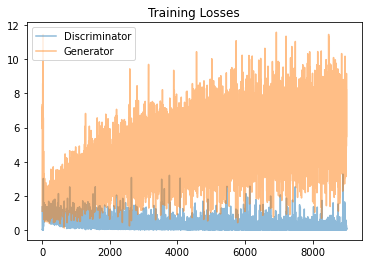

In [112]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [113]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [116]:
# Load samples from generator, taken while training
with open(picke_file, 'rb') as f:
    samples = pkl.load(f)

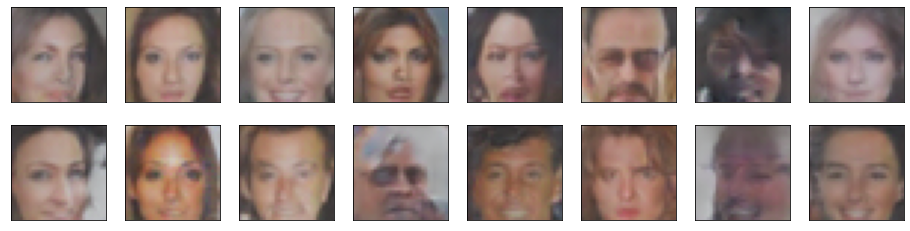

In [117]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.